This is for using 4 channels, one brightfield and 3 fluorescent in the autoencoder.

### This is using compensated images
- Data directory: '/media/cjw/Data/cyto/mmFromTifs3/'
- Checkpoint directory;: "/media/cjw/Data/cyto/Checkpoints/2018-04-17-Chs-0-1-2-4_32_mmFromTifs3/checkpoint-2018-04-17-10-18-24/"
- Checkpoint file: 'autoencoder-256x-13980.meta'

In [1]:
import sys

In [2]:
sys.executable

'/home/cjw/anaconda3/envs/deep/bin/python'

In [3]:
'''
Import the modules that will be used
'''

import sys
import warnings
from distutils.version import LooseVersion
import os

import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import hdbscan

from autoencoder import network_vae
from autoencoder import utils

%matplotlib inline
%pwd

/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'/media/cjw/PythonLib/cjwdeeplearning/autoencoder'

In [4]:
tf.__version__

'1.8.0'

In [5]:
datadir =  '/media/cjw/Data/MNIST/'
#datadir =  '/media/cjw/Data/cyto/ChannelOne/'

#cp_dir = '/home/cjw/disk2cjw/PythonLib/cjwdeeplearning/autoencoder/checkpoint-2018-03-19-11-19-18/'

cp_dir = "/media/cjw/Data/cyto/Checkpoints/2018-06-05-MNIST-VAE/checkpoint-2018-06-06-09-52-56/"
aemeta = 'autoencoder-64x-46700.meta'

if os.path.exists(cp_dir + aemeta):
    print("OK")

OK


In [6]:
'''
Define the neural network that was used and define hyper-parameters.
These are needed to infer from the saved network checkpoint
'''

tf.reset_default_graph()
                  
print(cp_dir)

if os.path.exists(cp_dir):
    print("OK, exists")
else:
    print("Oh no")
#checkpoint-2018-03-02-16-31-42/'
p_width = 28
p_height = 28
p_nchannels = 1
p_channels = [0]
p_nepochs = 100
p_batchsize = 128
p_learning_rate = 0.0002  #.00005
p_restore = False
p_latent_size = 64
p_droprate = 0.95
p_stdev = .04



enc_sizes = [(32, 3), (64, 3)] #[(128, 3), (256, 3)] #, (512, 3)] 
#enc_sizes = [(128, 3), (256, 3), (512,3), (1024,3)] #, (64, 3), (128,3)] #, (32, 3), (64, 3)]
dec_sizes = list(reversed(enc_sizes))
# enc_sizes = [(64, 5), (128, 3), (256,3), (512,3)]
# dec_sizes = list(reversed(enc_sizes))


sess = tf.Session()

images = tf.placeholder(tf.float32, (None, p_height, p_width, p_nchannels))
z = tf.placeholder(tf.float32, (None, p_latent_size))

z_mean, z_std = network_vae.encoder(images, p_latent_size, droprate=p_droprate, is_train=False,
                      nfilters=enc_sizes)

vae_z = network_vae.guess_z(z_mean, z_std, p_batchsize, p_latent_size)

sdd = network_vae.decoder(vae_z, nchannels=p_nchannels, width=p_width, droprate=p_droprate,
                      is_train=False, nfilters=dec_sizes)

loss, _, _ = network_vae.vae_loss(images, sdd, vae_z, z_mean, z_std, 0.0005)

opt = network_vae.model_opt(loss, p_learning_rate)
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())
saver = tf.train.import_meta_graph(cp_dir + aemeta) #autoencoder-64x-18660.meta')
saver.restore(sess, tf.train.latest_checkpoint(cp_dir + ''))


/media/cjw/Data/cyto/Checkpoints/2018-06-05-MNIST-VAE/checkpoint-2018-06-06-09-52-56/
OK, exists
Encoder False
Tensor("Placeholder:0", shape=(?, 28, 28, 1), dtype=float32) (?, 28, 28, 1)
isize:  7 28
dh0 (?, 28, 28, 1)
INFO:tensorflow:Restoring parameters from /media/cjw/Data/cyto/Checkpoints/2018-06-05-MNIST-VAE/checkpoint-2018-06-06-09-52-56/autoencoder-64x-46700


In [7]:
#datadir = "/media/cjw/Data/cyto/mmFromTifs/"
#datadir = "/home/cjw/disk2cjw/Data/yeast/"
mmfiles = utils.list_mmfiles(datadir)
print(mmfiles)

mmdict = dict()

n_all_images = 0
for mmfilename in mmfiles:
#mmfilename = datadir + "Fish6_15_cjw_mean_zero.mm"
#mmfilename = datadir + "mmplate15-1.mm"
    mmheader = np.memmap(mmfilename, dtype="int32", mode='r',
                    shape=(4,))

    header_shape = mmheader.shape
    print(header_shape, mmheader)
    xshape = [mmheader[0], mmheader[1], mmheader[2], mmheader[3]]
    xshape = tuple(xshape)
    del mmheader
    n_all_images += xshape[0]
    
    m3 = np.memmap(mmfilename, dtype='float32', offset=128,
              mode='r', shape=xshape)
    key = mmfilename.split("/")[-1]
    mmdict[key] = m3

print(n_all_images)
mmdict.keys()

['/media/cjw/Data/MNIST/mnist.mm']
(4,) [60000    28    28     1]
60000


dict_keys(['mnist.mm'])

In [36]:
label_file ='/media/cjw/Data/MNIST/train-labels-idx1-ubyte'
labmm = np.memmap(label_file, dtype=np.uint8, mode='r', offset=8, shape=(60000))
labels = np.zeros((60000))
labels[:] = labmm
labels
del labmm

n = xshape[0]
all_ids =  range(n_all_images)
idx = 0
dataframes = list()
for key in mmdict.keys():
    mm = mmdict[key]
    n = mm.shape[0]
    print(n)
    file = n*[key[0:-3]]
    fid = range(n)
    mmfile = n*[key]
    plate = n*[0]
    row = n*[0]
    column = n*[0]
    field = n*[0]
    yc = n*[32]
    xc = n*[32]
    well = n*[0]
    ids = all_ids[idx:idx + n]
    idx += n
    xdf = pd.DataFrame({'id':ids, 'fid':fid, 'file':file, 'mmfile':mmfile, 'plate':plate,
                     'row':row, 'column':column, 'field':field,
                      'yc':yc, 'xc':xc, 'well':well})

    dataframes.append(xdf)
    
alldf = pd.concat(dataframes, ignore_index=True)
trts = list()
runs = list()

for row in range(len(alldf)):
    file = alldf.iloc[row]['file']
    if '_ice' in file.lower():
        treatment = 'ice'
    elif '_ccb'in file.lower():
        treatment = 'ccb'
    else:
        treatment = "untreated"
    trts.append(treatment)
    runs.append(file[0:5])

alldf['label'] = labels
alldf['treatment'] = trts
alldf['run'] = runs
df = alldf.sample(frac=.1)
df = df.reset_index()
print(len(df))
df.tail()

60000
6000


,index,column,fid,field,file,id,mmfile,plate,row,well,xc,yc,label,treatment,run
5995,27071,0,27071,0,mnist,27071,mnist.mm,0,0,0,32,32,1.0,untreated,mnist
5996,41560,0,41560,0,mnist,41560,mnist.mm,0,0,0,32,32,8.0,untreated,mnist
5997,53644,0,53644,0,mnist,53644,mnist.mm,0,0,0,32,32,2.0,untreated,mnist
5998,26929,0,26929,0,mnist,26929,mnist.mm,0,0,0,32,32,3.0,untreated,mnist
5999,23495,0,23495,0,mnist,23495,mnist.mm,0,0,0,32,32,0.0,untreated,mnist


In [37]:
sns.set_style("whitegrid", {'axes.grid' : False})
len(df)

6000

In [38]:
'''Read the images, display image, encode and show latent space, show decoded'''

vv = utils.getWell(mmdict,
                    df, p_width, 0, 0, p_nchannels, channels=p_channels)

nvv = len(vv)
offloc = 0
offstep = p_batchsize
offnext = offloc + offstep
xhe = np.zeros((nvv, p_latent_size))
xdd = np.zeros((nvv, p_width, p_height, p_nchannels))
while offloc < nvv:
    #print(offloc, offnext)
#     zm, zs = sess.run([z_mean, z_std], feed_dict={images:vv[offloc:offnext]})
#     dv  = offnext - offloc
#     vz = sess.run(network_vae.guess_z(zm, zs, dv, p_latent_size))
    xhe[offloc:offnext] = sess.run(vae_z, feed_dict={images:vv[offloc:offnext]})
    xdd[offloc:offnext] = sess.run(sdd, feed_dict={images:vv[offloc:offnext]})
    offloc = offnext
    offnext += offstep
    if offnext > nvv:
        offnext = nvv
        
f = plt.figure(figsize=(12, 40))
print(xhe.shape, xdd.shape)
print(np.amin(vv),np.amax(vv))
# for i in range(5):
#     ix = np.random.randint(0, len(vv))
#     #print(ix)
#     plt.subplot(20,3,i*3 + 1)
#     plt.imshow(vv[ix,:,:,0])
#     plt.subplot(20,3,i*3 + 2)
#     plt.plot(xhe[ix])
#     plt.subplot(20,3,i*3 + 3)
#     plt.imshow(xdd[ix,:,:,0])
   

(6000, 64) (6000, 28, 28, 1)
0.0 1.0


<Figure size 864x2880 with 0 Axes>

In [12]:
xhemm = np.memmap('/media/cjw/Data/cyto/latent_space_256.mm', dtype=np.float32, mode='w+', shape=xhe.shape)
xhemm[:] = xhe[:]
del xhemm

In [12]:
def one_imshow(image, r, c, ic, cmap):
    plt.subplot(16, 8, ic)
    plt.imshow(image, cmap=cmap)
    plt.axis('off')

ic = 1

nrows = 6
plt.figure(figsize=(16,4*nrows))

# for i in range(nrows):
#     ix = np.random.randint(0, len(vv))
#     one_imshow(vv[ix,:,:,0], nrows, 8, ic, 'gray')
#     ic += 1
    
#     one_imshow(vv[ix,:,:,1], nrows, 8, ic, 'viridis')
#     ic += 1
    
#     one_imshow(vv[ix,:,:,2], nrows, 8, ic, 'plasma')
#     ic += 1
    
#     one_imshow(vv[ix,:,:,3], nrows, 8, ic, 'afmhot')
#     ic += 1
    
#     one_imshow(xdd[ix,:,:,0], nrows, 8, ic, 'gray')
#     ic += 1
    
#     one_imshow(xdd[ix,:,:,1], nrows, 8, ic, 'viridis')
#     ic += 1
    
#     one_imshow(xdd[ix,:,:,2], nrows, 8, ic, 'plasma')
#     ic += 1
    
#     one_imshow(xdd[ix,:,:,3], nrows, 8, ic, 'afmhot')
#     ic += 1

#plt.savefig('/media/cjw/Data/cyto/output/decoded.png')

<Figure size 1152x1728 with 0 Axes>

<Figure size 1152x1728 with 0 Axes>

In [39]:
'''Encode the images with the trained network and store the latent spaces in an array'''

dv = {0:(0,0)}
dimages = dict()
counter = 0
one = 0
for k in dv.keys():
    i, j = dv[k]
    print(i, j)
    r = i + 1
    cm = j + 1
    try:
        k = vv #utils.getWell(mmdict,df, width, 0, 0, nchannels, channels=[0])
        print(len(k))
    except:
        print("Oh no!!")
        continue
    hek = xhe #sess.run(enc, feed_dict={images:k})
    print('hek', hek.shape)
    dimages[counter] = k
    if one == 0:
        one = 1
        g = hek
        colors = np.zeros(k.shape[0])
        counter += 1
        print(i, j, g.shape, hek.shape)
    else:
        print(i, j, g.shape, hek.shape)
        g = np.concatenate((g,hek))
        colors = np.concatenate((colors, counter + np.zeros(k.shape[0])))
        counter += 1

g_all = g
g_all.shape

0 0
6000
hek (6000, 64)
0 0 (6000, 64) (6000, 64)


(6000, 64)

In [13]:
ops = sess.graph.get_operations()
for op in ops:
    print(op.values())


(<tf.Tensor 'Placeholder:0' shape=(?, 28, 28, 1) dtype=float32>,)
(<tf.Tensor 'Placeholder_1:0' shape=(?, 64) dtype=float32>,)
(<tf.Tensor 'filter_00/kernel/Initializer/truncated_normal/shape:0' shape=(4,) dtype=int32>,)
(<tf.Tensor 'filter_00/kernel/Initializer/truncated_normal/mean:0' shape=() dtype=float32>,)
(<tf.Tensor 'filter_00/kernel/Initializer/truncated_normal/stddev:0' shape=() dtype=float32>,)
(<tf.Tensor 'filter_00/kernel/Initializer/truncated_normal/TruncatedNormal:0' shape=(3, 3, 1, 128) dtype=float32>,)
(<tf.Tensor 'filter_00/kernel/Initializer/truncated_normal/mul:0' shape=(3, 3, 1, 128) dtype=float32>,)
(<tf.Tensor 'filter_00/kernel/Initializer/truncated_normal:0' shape=(3, 3, 1, 128) dtype=float32>,)
(<tf.Tensor 'filter_00/kernel:0' shape=(3, 3, 1, 128) dtype=float32_ref>,)
(<tf.Tensor 'filter_00/kernel/Assign:0' shape=(3, 3, 1, 128) dtype=float32_ref>,)
(<tf.Tensor 'filter_00/kernel/read:0' shape=(3, 3, 1, 128) dtype=float32>,)
(<tf.Tensor 'filter_00/bias/Initialize

(<tf.Tensor 'dense/kernel/Adam_1/Initializer/zeros_1:0' shape=(64, 12544) dtype=float32>,)
(<tf.Tensor 'dense/kernel/Adam_1/Assign_1:0' shape=(64, 12544) dtype=float32_ref>,)
(<tf.Tensor 'dense/kernel/Adam_2:0' shape=(64, 12544) dtype=float32_ref>,)
(<tf.Tensor 'save/Assign_18_1:0' shape=(64, 12544) dtype=float32_ref>,)
(<tf.Tensor 'dense/kernel/Adam/read_1:0' shape=(64, 12544) dtype=float32>,)
(<tf.Tensor 'dense/kernel/Adam/Initializer/zeros/Const_1:0' shape=() dtype=float32>,)
(<tf.Tensor 'dense/kernel/Adam/Initializer/zeros/shape_as_tensor_1:0' shape=(2,) dtype=int32>,)
(<tf.Tensor 'dense/kernel/Adam/Initializer/zeros_1:0' shape=(64, 12544) dtype=float32>,)
(<tf.Tensor 'dense/kernel/Adam/Assign_1:0' shape=(64, 12544) dtype=float32_ref>,)
(<tf.Tensor 'latent_space/bias/Adam_1_1:0' shape=(64,) dtype=float32_ref>,)
(<tf.Tensor 'save/Assign_34_1:0' shape=(64,) dtype=float32_ref>,)
(<tf.Tensor 'latent_space/bias/Adam_1/read_1:0' shape=(64,) dtype=float32>,)
(<tf.Tensor 'latent_space/bias

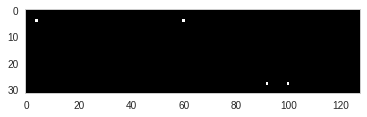

In [197]:
inum = 107
samp = np.zeros((1,32,32,1))
samp[0,4, 4, 0] = .8
samp[0,4, 28, 1] = .8
samp[0,28, 28, 2] = .8
samp[0,28, 4, 3] = .8
filt, kern = sess.run([tf.get_default_graph().get_tensor_by_name('mul:0'),
                tf.get_default_graph().get_tensor_by_name('filter_00/kernel:0')],
                feed_dict={images:samp}) #vv[inum:inum + 1]})

th = np.zeros((32,32*4))
th[0:32,0:32] = samp[0,:,:,0] #vv[inum,:,:,0]
th[0:32,32:64] = samp[0,:,:,1] #vv[inum,:,:,1]
th[0:32,64:96] = samp[0,:,:,2] #vv[inum,:,:,2]
th[0:32,96:128] = samp[0,:,:,3] #vv[inum,:,:,3]
plt.imshow(th, cmap='gray')

In [14]:
ki = 43
kz = np.zeros((3,12))
kz[0:3, 0:3] = kern[:,:,0,ki]
kz[0:3, 3:6] = kern[:,:,1,ki]
kz[0:3, 6:9] = kern[:,:,2,ki]
kz[0:3, 9:12] = kern[:,:,3,ki]
plt.subplot(2,1,1)
plt.imshow(kz, cmap='plasma')
plt.subplot(2,1,2)
plt.imshow(filt[0,:,:,ki], cmap='plasma')
# plt.subplot(2,4,6)
# plt.imshow(filt[0,:,:,ki], cmap='gray')
# plt.subplot(2,4,7)
# plt.imshow(filt[0,:,:,ki], cmap='gray')
# plt.subplot(2,4,8)
# plt.imshow(filt[0,:,:,ki], cmap='gray')

kern.shape

NameError: name 'kern' is not defined

(1, 16, 16, 128)
[  0  16  32  48  64  80  96 112]
[  0  16  32  48  64  80  96 112 128 144 160 176 192 208 224 240]


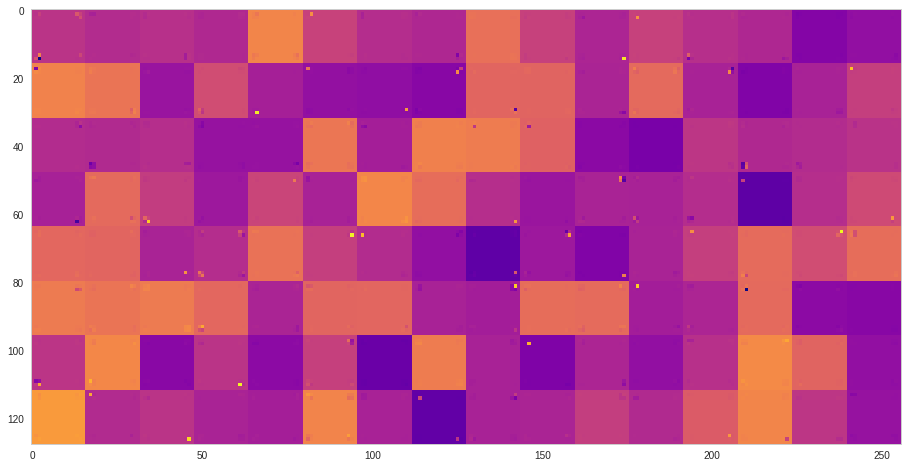

In [191]:
print(filt.shape)

sz = 16
p = np.zeros((sz*8, sz*16))

e0 = np.arange(0, sz*8, sz)
e1 = np.arange(0, sz*16, sz)
print(e0)
print(e1)
index = 0
for i in e0:
    for j  in e1:
        p[i:i+sz, j:j+sz] = filt[0,:,:,index]
        index += 1
plt.figure(figsize=(sz,sz/2))
plt.imshow(p, cmap='plasma')

In [12]:
''' Create some colors for display later on'''

from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
clist = [(.2,.2,.2),
         (172/255,25/255,210/255),
         (255/255, 165./255, 0),
         (44/255,25/255,210/255),
         (134/255, 165./255, 56/255),
         (26/255,188/255,255/255),
         (188/255,255/255, 26/255),
         (1, 0,0), (0,1,0), (0,0,1)]

mycmap = LinearSegmentedColormap.from_list(
        'mycmap', clist, N=len(clist))

bounds = np.linspace(0, len(clist), len(clist) + 1)
norm = mpl.colors.BoundaryNorm(bounds, mycmap.N)
print(bounds, mycmap.N)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] 10


In [13]:
'''Do PCA on the latent space features'''

from sklearn.decomposition import PCA
pca = PCA(n_components=31, svd_solver='arpack', whiten=True, copy=True)
gfit = pca.fit_transform(g_all)
print(gfit.shape)
print(pca.explained_variance_)
print(pca.components_.shape)


(6000, 31)
[0.62569725 0.60336056 0.52378944 0.4987061  0.47972848 0.46743765
 0.45482126 0.44516997 0.43937339 0.42479023 0.41212351 0.40639678
 0.39371636 0.3894096  0.36779152 0.36228948 0.35678547 0.34813266
 0.33817021 0.33559156 0.33180388 0.32838904 0.32280821 0.31872972
 0.31152444 0.30651392 0.30469825 0.30063323 0.29614758 0.29364128
 0.2904605 ]
(31, 64)


In [56]:
'''
Do clustering on the latent space features
find eight cluster for K-Means and Allomerative Clustering
'''

nclust = 10
from sklearn import cluster, mixture
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

km = cluster.KMeans(n_clusters=nclust).fit_predict(g_all)
agc = cluster.AgglomerativeClustering(n_clusters=nclust, affinity='euclidean', linkage="ward").fit_predict(g_all)
gmm = BayesianGaussianMixture(nclust, covariance_type='full')
gmm.fit(g_all)
gm = gmm.predict(g_all)

In [15]:
km = cluster.KMeans(n_clusters=nclust).fit_predict(g_all)

###  Show results of clustering using K-Means

Each row is a cluster found using the K-Means algorithm. The images are randomly selected from each cluster.
The image in the first column of every row is decoded from the average of the latent space features for each cluster.

/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


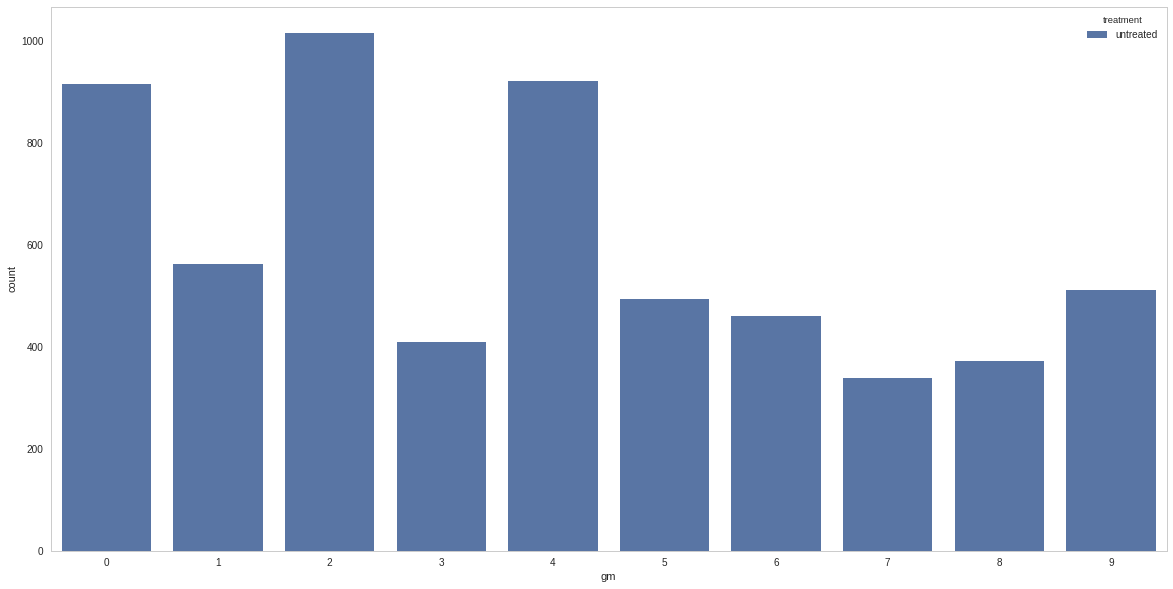

In [15]:
#km = gm
df['km'] = km
df['gm'] = gm
plt.figure(figsize=(20,10))
sns.set_style("whitegrid", {'axes.grid' : False})
sns.countplot(x='gm', data=df, hue='treatment')

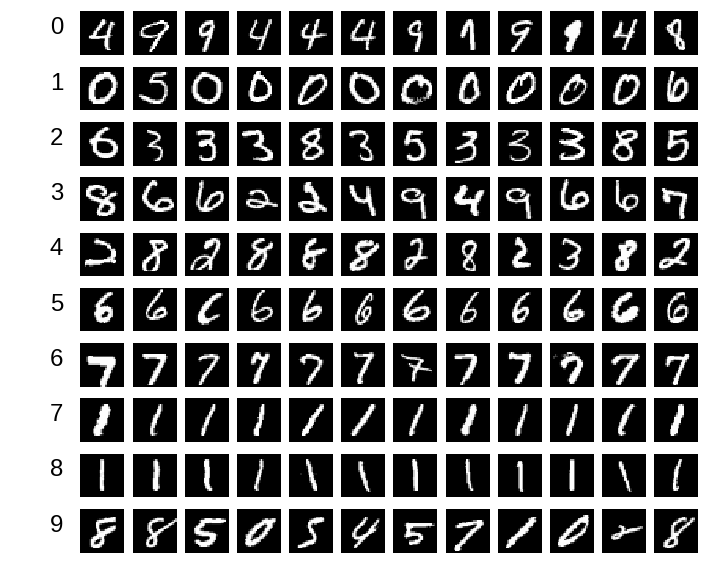

In [16]:
ximages = vv
nk = nclust
plt.figure(figsize=(12, 1.*nk))
plt.ion()
counter = 1
shift = 0
for k in range(nk):
    rowdf = df[df['gm'] == k]
    inum = list(rowdf.index)
    
    gk = g_all[gm == k]
    gavk = np.mean(gk, axis=0)
    gavk = np.expand_dims(gavk.squeeze(), axis=0)
    resav = sess.run(sdd, feed_dict={vae_z:gavk})
#     plt.subplot(nk, 12, counter)
#     plt.imshow(resav.squeeze()[0])
#     plt.text(8, 12,str(k), fontsize=36, color='black')
#     counter += 1
    plt.subplot(nk, 13, counter)
    plt.text(0.5,0.5, str(k), fontsize=24, color='black')
    plt.axis('off')
    counter += 1
    for i in range(12):
        
        try:
            plt.subplot(nk, 13, counter)
            rnd = inum[np.random.randint(0,len(inum))]
            plt.imshow(ximages[rnd,:,:,0], cmap='gray')
            plt.axis('off')
            counter += 1
    
        except Exception as e:
            print(e)
            plt.imshow(np.zeros((64,64)), cmap='gray')
            counter += 1

###  Show results of clustering using Agglomerative Clustering

Each row is a cluster found using the [Agglomerative Clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)
algorithm. The images are randomly selected from each cluster.
The image in the first column of every row is decoded from the average of the latent space features for each cluster.

/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


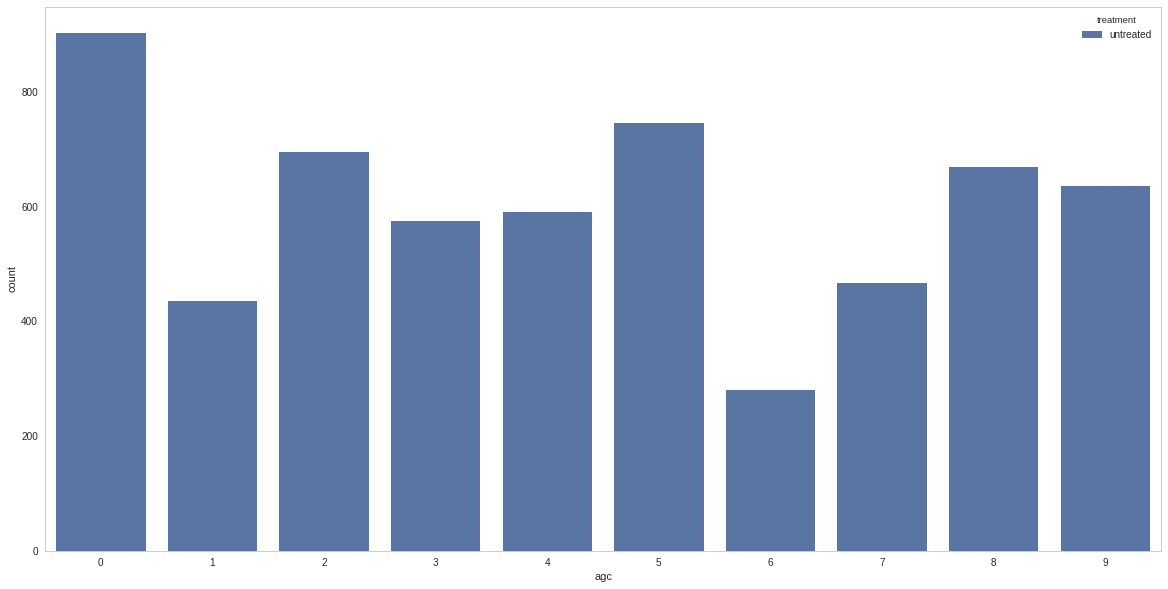

In [17]:
df['agc'] = agc
plt.figure(figsize=(20,10))
sns.countplot(x='agc', data=df, hue='treatment')
plt.savefig('/media/cjw/Data/cyto/output/agc_filedist.png')

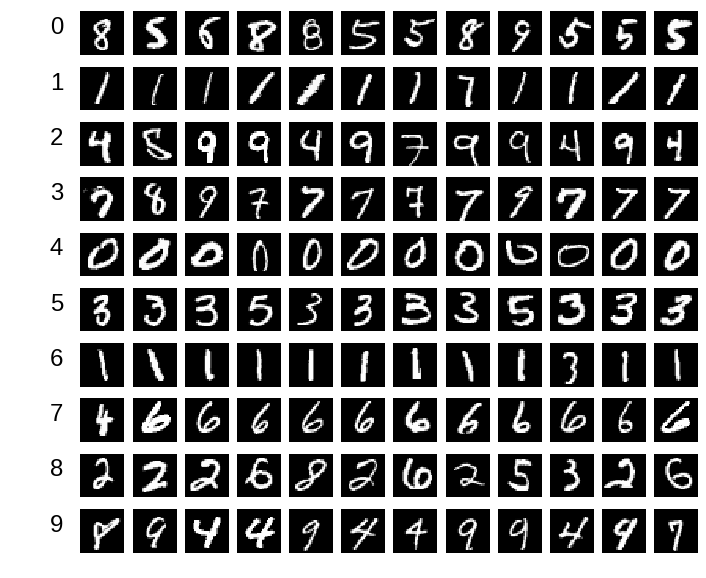

In [18]:
ximages = vv
nk = nclust
plt.figure(figsize=(12, 1.*nk))
plt.ion()
counter = 1
shift = 0
for k in range(nk):
    rowdf = df[df['agc'] == k]
    inum = list(rowdf.index)
    
    gk = g_all[agc == k]
    gavk = np.mean(gk, axis=0)
    gavk = np.expand_dims(gavk.squeeze(), axis=0)
    resav = sess.run(sdd, feed_dict={vae_z:gavk})
#     plt.subplot(nk, 12, counter)
#     plt.imshow(resav.squeeze()[0])
#     plt.text(8, 12,str(k), fontsize=36, color='black')
#     counter += 1
    plt.subplot(nk, 13, counter)
    plt.text(0.5,0.5, str(k), fontsize=24, color='black')
    plt.axis('off')
    counter += 1
    for i in range(12):
        
        try:
            plt.subplot(nk, 13, counter)
            rnd = inum[np.random.randint(0,len(inum))]
            plt.imshow(ximages[rnd,:,:,0], cmap='gray')
            plt.axis('off')
            counter += 1
    
        except Exception as e:
            print(e)
            plt.imshow(np.zeros((64,64)), cmap='gray')
            counter += 1

-------------------------------------------------------------------------

In [20]:
import matplotlib 
def display_cluster(cluster_num, nrows=16, outfile=None):
    
    if outfile:
        plt.ioff()
    tn = cluster_num
    images4 = ximages[agc == tn]
    g4 = g_all[agc == tn]
    fig = plt.figure(figsize=(16,1.6*1.5*nrows))
    #print(images4.shape)

#     gtest = np.mean(g4, axis=0)
#     gtest = np.expand_dims(gtest.squeeze(), axis=0)
#     res = sess.run(sdd, feed_dict={enc:gtest})

#     gav = np.mean(g_all, axis=0)
#     gav = np.expand_dims(gav.squeeze(), axis=0)
#     resav = sess.run(sdd, feed_dict={enc:gav})

    ppi = 0
    for i in range(nrows):
        ix = np.random.randint(0, len(g4))
        plt.subplot(nrows,8,i*8 + 1)
        plt.imshow(images4[ix,:,:,0], cmap='gray')
        plt.axis('off')

#         plt.subplot(nrows,8,i*8 + 2)
#         plt.imshow(images4[ix,:,:,1], cmap='viridis')
#         plt.axis('off')

#         plt.subplot(nrows,8, i*8 + 3)
#         plt.imshow(images4[ix,:,:,2], cmap='plasma')
#         plt.axis('off')

#         plt.subplot(nrows,8,i*8 + 4)
#         plt.imshow(images4[ix,:,:,3], cmap='afmhot')
#         plt.axis('off')

        plt.subplot(nrows, 2, i*2 + 2)
        plt.plot(g4[ix]*0, color='gray')
        plt.plot(g4[ix])

    #     plt.xticks([])
    #     plt.yticks([])
        plt.axis('off')
        ppi += 2
    if outfile:
        #fig = matplotlib.pyplot.gcf()
        #fig.set_size_inches(4, 10)
        #fig.savefig('test2png.png', dpi=100)
        plt.savefig(outfile, dpi=100)
        plt.clf()
        plt.close(fig)
#     plt.show()
    plt.ion()



In [96]:
for i in range(nclust):
    outfile = "/media/cjw/Data/cyto/output/cluster_" + str(i).zfill(3) + ".png"
    display_cluster(i, 8, outfile=outfile)

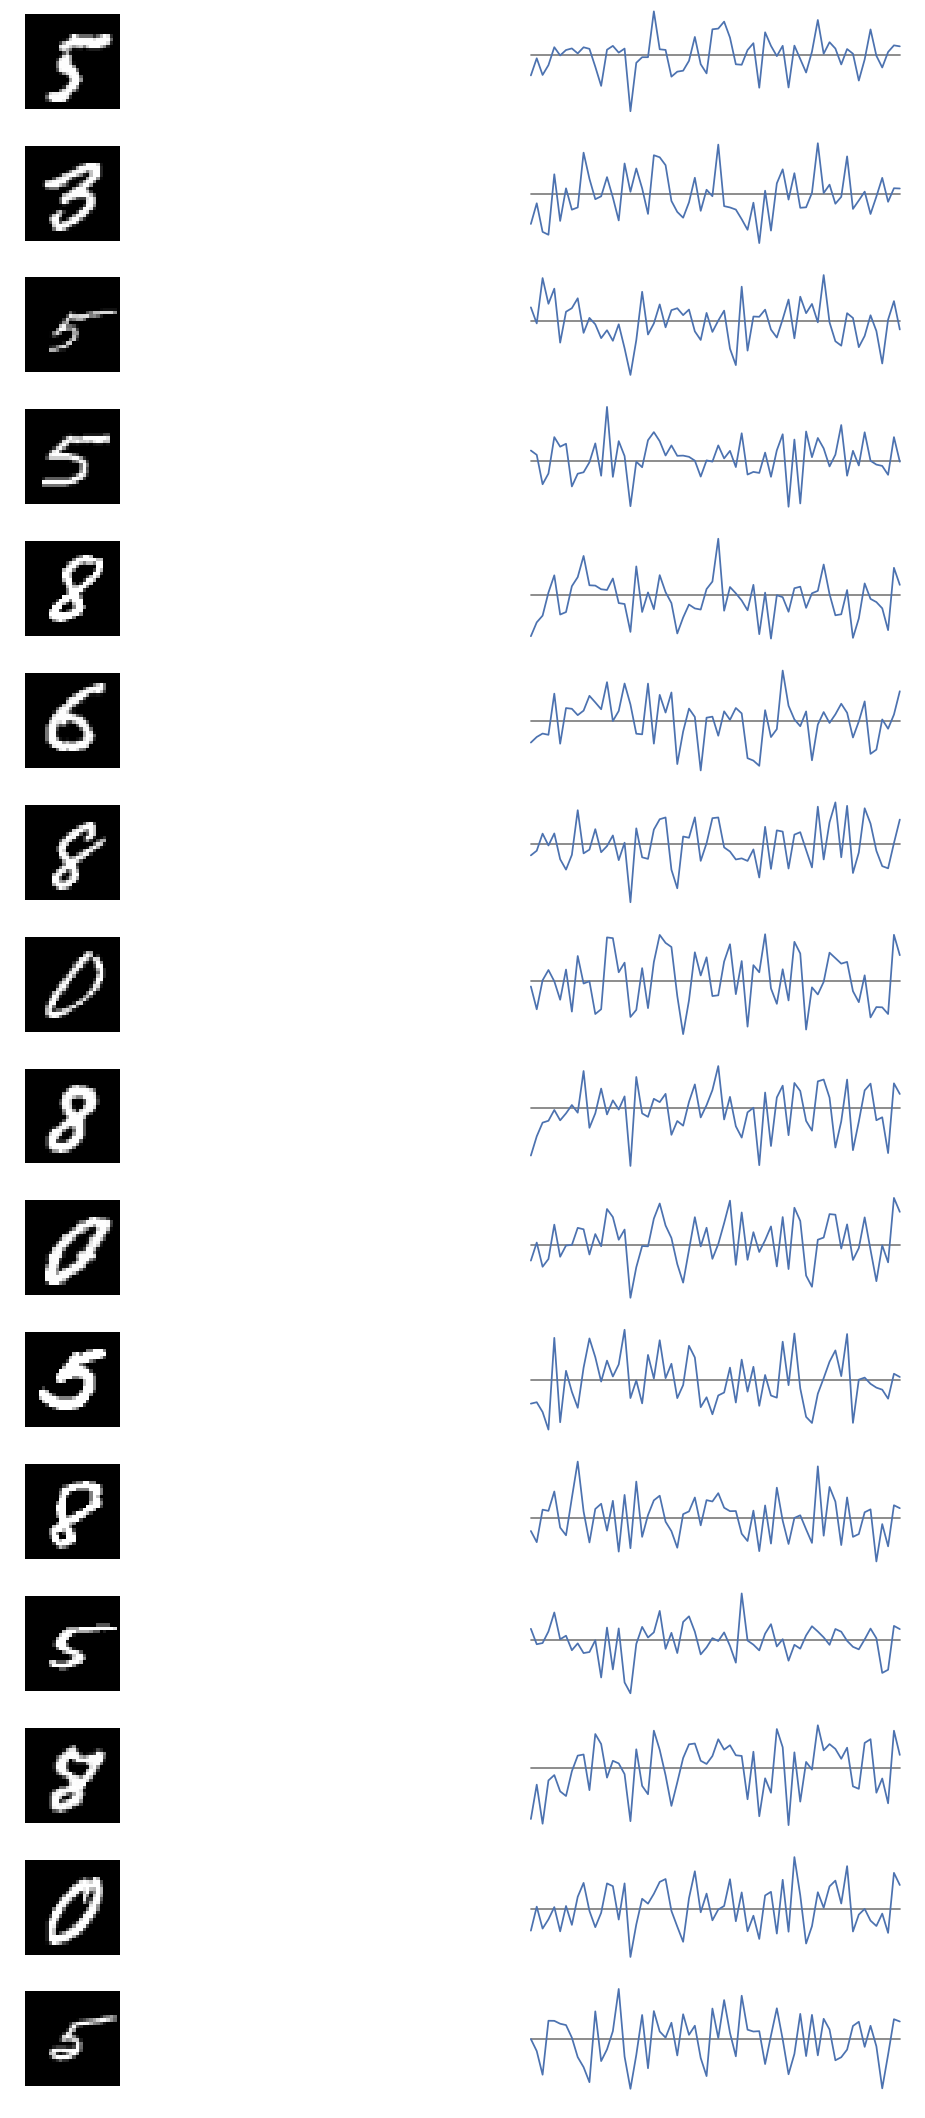

In [21]:
display_cluster(2, 16, outfile=None)
# plt.show()

In [65]:
from sklearn.manifold import TSNE

# geez = list()
# ceez = list()
# cindex = 0
# for i in (16,17, 18,19):
#     gna = g_all[agc == i]
#     ca = cindex #np.array(clist[cindex])
#     cna = np.repeat([i], gna.shape[0], axis=0)
#     geez.append(gna)
#     ceez.append(cna)
#     cindex += 1
# # c3 = gn3.shape[0]*(1, 0, 0)
# # c6 = gn3.shape[0]*(0, 1, 0)
# # c10 = gn3.shape[0]*(0, 0, 1)
# gn = np.concatenate(geez)
# cn = np.concatenate(ceez)
# cn = np.concatenate((c3, c6, c10))
#print(gn.shape)
g_emb = TSNE(n_components=2,perplexity=40).fit_transform(g_all.astype(np.float64))
print(g_emb.shape)



(6000, 2)


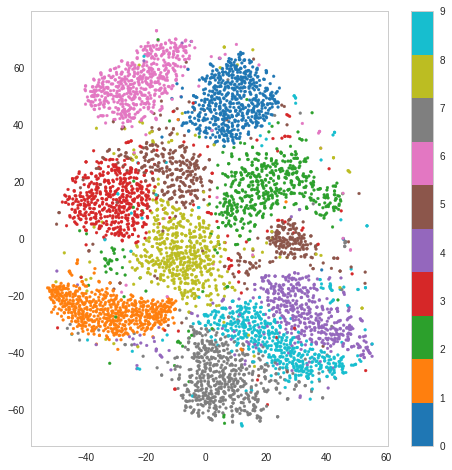

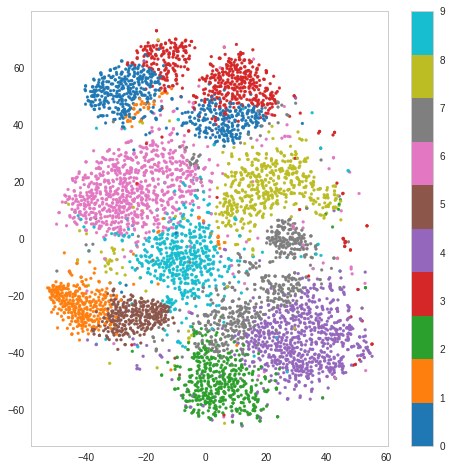

In [67]:
plt.figure(figsize=(8,8))
plt.scatter(g_emb[:,0], g_emb[:,1], 8, df['label'], cmap='tab10')
plt.colorbar()

plt.figure(figsize=(8,8))
plt.scatter(g_emb[:,0], g_emb[:,1], 8, gm, cmap='tab10')
plt.colorbar()

529 608
(1, 28, 28, 1)
402 6.414367 (529, 64)
(1, 28, 28, 1)


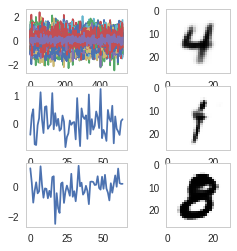

In [235]:
za2 = df[df['label'] == 4].index
za4 = df[df['label'] == 8].index
print(len(za2), len(za4))
# plt.imshow(vv[za1,:,:,0], cmap='gray')

feed2 = vv[za2]
feed4 = vv[za4]
print(feed.shape)
z2, zm2 = sess.run([vae_z, z_mean], feed_dict={images:feed2})
z4, zm4 = sess.run([vae_z, z_mean], feed_dict={images:feed4})

r2 = sess.run(sdd, feed_dict={vae_z:z2})
r4 = sess.run(sdd, feed_dict={vae_z:z4})

plt.figure(figsize=(4,4))
plt.plot(z2[0])
plt.plot(z4[0])

z2m = np.mean(z2, axis=0)

dm = zm2 - z2m
nrm = np.linalg.norm(zm2, axis =1)

xs= np.argmax(nrm)
mns = np.argmin(nrm)
print(xs, nrm[xs], zm2.shape)
fz2m = np.expand_dims(z2m, 0)
z4m = z2[mns] #np.mean(z4, axis=0)
fz4m = np.expand_dims(z4m, 0)
rm2 = sess.run(sdd, feed_dict={vae_z:fz2m})
rm4 = sess.run(sdd, feed_dict={vae_z:fz4m})
print(rm.shape)

fzmd = np.expand_dims(zm4[0] + (zm4[0] - zm2[0])/2, 0)
rmd = sess.run(sdd, feed_dict={vae_z:fzmd})

plt.subplot(3,2,1)
plt.plot(zm2)
plt.subplot(3,2,2)
plt.imshow(rm2[0,:,:,0])
plt.subplot(3,2,3)
plt.plot(z4m)
plt.subplot(3,2,4)
plt.imshow(rm4[0,:,:,0])

plt.subplot(3,2,5)
plt.plot(fzmd[0])
plt.subplot(3,2,6)
plt.imshow(rmd[0,:,:,0])

In [216]:
from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist, cdist

# dm =  np.arccos(1 -cdist(z2,z2, metric='cosine'))
dm = z2 - z2m
print(dm.shape)
nrm = np.linalg.norm(dm, axis =1)

print(nrm.shape)
print(np.argmax(nrm))
#dm =  cdist(g_all, g_all, metric='euclidean')
#dm = distance_matrix(mma, mma)
print(dm.shape)

ddict = dict()
for i in range(z2.shape[0]):
    ri = np.argsort(dm[i])
    ddict[i] = ri[1:13]

imx = np.argmax(dm)
imx, imx // 536, imx % 536
#dm[109, 522]



(612, 64)
(612,)
388
(612, 64)


(23091, 43, 43)

In [42]:
from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist, cdist

dm =  np.arccos(1 -cdist(g_all,g_all, metric='cosine'))
#dm =  cdist(g_all, g_all, metric='euclidean')
#dm = distance_matrix(mma, mma)
print(dm.shape)

ddict = dict()
for i in range(g_all.shape[0]):
    ri = np.argsort(dm[i])
    ddict[i] = ri[1:13]

dm[1,ddict[1]]

(6000, 6000)


array([1.04362374, 1.04485095, 1.06175792, 1.08374112, 1.09075287,
       1.10007973, 1.10082507, 1.10319641, 1.10522954, 1.10918889,
       1.11484772, 1.11681372])

In [43]:
from fa2 import ForceAtlas2
import networkx as nx
ft = ForceAtlas2()

gx = nx.Graph()
pos = dict()
for i in range(g_all.shape[0]):
    gx.add_node(i)
    r1 = np.random.randint(-50, 50)
    r2 = np.random.randint(-50, 50)

In [44]:
index = 0
edges = list()
enum = 0
xnum = 0
for i in range(g_all.shape[0]):
    if i % 1000 == 0:
        print(i, xnum, enum, gx.size())
    for k in ddict[i]:
        if i == k:
            continue
   
        w = 1 #1./(w*w)
        if gx.has_edge(k, i):
            xnum += 1
        gx.add_edge(i, k, weight=w) #, weight=w)
        enum += 1
        #index += 1

print(enum, xnum)
#g.add_edges_from(edges)
#g.add_weighted_from(len(edges)*[1.])
len(gx.nodes()), len(gx.edges())

0 0 0 0
1000 697 12000 11303
2000 2708 24000 21292
3000 6306 36000 29694
4000 11159 48000 36841
5000 17405 60000 42595
72000 25132


(6000, 46868)

In [45]:
ft = ForceAtlas2( # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=0.,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          #multiThreaded=True,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=20.,
                          strongGravityMode=False,
                          gravity= .0,

                          # Log
                          verbose=True)

In [46]:
p = ft.forceatlas2_networkx_layout(gx, pos=None, iterations=500)

100%|██████████| 500/500 [00:32<00:00, 15.38it/s]

BarnesHut Approximation  took  15.41  seconds
Repulsion forces  took  15.37  seconds
Gravitational forces  took  0.12  seconds
Attraction forces  took  0.35  seconds
AdjustSpeedAndApplyForces step  took  0.61  seconds


/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:


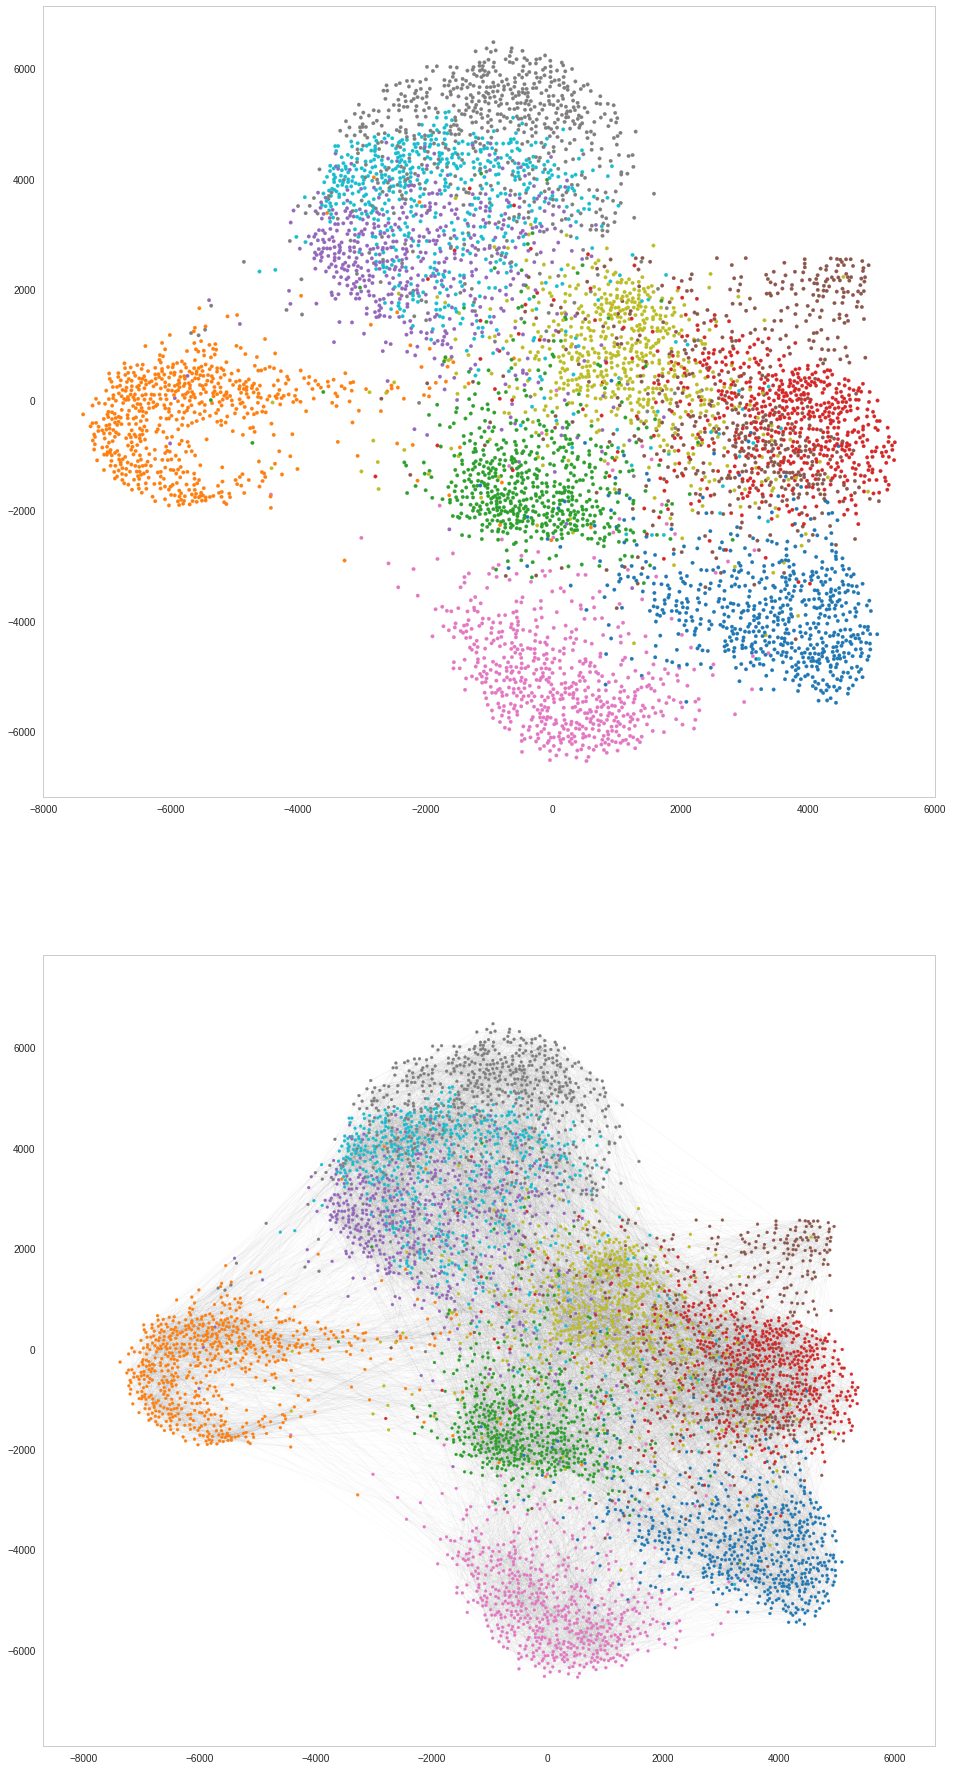

In [51]:
plt.figure(figsize=(16,32))
plt.subplot(2, 1, 1)
nx.draw_networkx_nodes(gx, p, node_size=12, with_labels=False, width=.004, node_color=df['label'], cmap='tab10')

plt.subplot(2,1,2)
nx.draw_networkx(gx, p, node_size=8, with_labels=False, width=.01, node_color=df['label'], cmap='tab10')